# Schrier Lab `contrastive` fork issue demonstration

Here we will use the Mice Protein Dataset example from the paper to illustrate our issue in extending `contrastive`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap
%matplotlib inline
warnings.filterwarnings('ignore')

# for plotting
cmap2 = ListedColormap(['r', 'k'])
cmap4 = ListedColormap(['k', 'r', 'g', 'b'])

### Load the Mice Protein Dataset

In [2]:
data = np.genfromtxt('datasets/Data_Cortex_Nuclear.csv',delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt('datasets/Data_Cortex_Nuclear.csv',delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

### Split by contrastive feature

In [3]:
target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

sub_group_labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))                                                                          

target = data[target_idx]
target = (target-np.mean(target,axis=0)) / np.std(target,axis=0) # standardize the dataset

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
# background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))
background = data[background_idx]
background = (background-np.mean(background,axis=0)) / np.std(background,axis=0) # standardize the dataset
labels = len(background)*[0] + len(target)*[1]
data = np.concatenate((background, target))

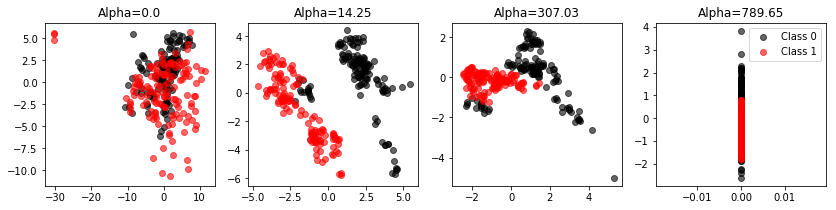

In [4]:
from contrastive import CPCA
mdl = CPCA()
projected_data = mdl.fit_transform(target, background, active_labels=sub_group_labels, plot=True)

## Disussion of issue

Above we see some results of CPCA on the Mice Protein dataset. When alpha=789.65, we would expect cPC1 to take account of nearly *all* of the variance in the dataset, and cPC2 to take account of nearly *none* of it. However, based on our extension of the code, this is not what we see: 

In [5]:
# mdl.bases is where we store information about the cPC basis sets, keyed by the alpha value
print("Result 1:\n")
print(mdl.bases[789.65]['variance_ratio'])

Result 1:

[-1.01461215e-18  5.96538890e-06]


According to our extension of the code, these vectors account for nearly *none* of the variance. That cant be right., 

Something interesting happens if we store *all* of the cPCs instead of just the top two: 

In [6]:
# rebuild the cPCA model retaining all cPCs
mdl2 = CPCA(n_components=data.shape[1])
projected_data = mdl2.fit_transform(target, background, active_labels=sub_group_labels)

print("Result 2:\n")
mdl2.bases[789.65]['variance_ratio']

Result 2:



array([-1.01461215e-18,  5.96538890e-06,  9.88324307e-06,  1.59169408e-05,
        1.84972298e-05,  2.26633783e-05,  2.70801084e-05,  2.94209642e-05,
        3.53876410e-05,  3.76956841e-05,  4.08976236e-05,  4.42461250e-05,
        5.34763015e-05,  5.84392181e-05,  6.82278377e-05,  7.39763171e-05,
        9.04160746e-05,  1.00461931e-04,  1.06086274e-04,  1.14708665e-04,
        1.24616456e-04,  1.29662241e-04,  1.42304658e-04,  1.55124717e-04,
        1.55983224e-04,  1.71015604e-04,  1.96052456e-04,  2.01806457e-04,
        2.10887451e-04,  2.45600571e-04,  2.72818559e-04,  2.94661560e-04,
        3.02790220e-04,  3.27856552e-04,  3.38790768e-04,  4.15526776e-04,
        4.24159268e-04,  4.54637503e-04,  4.93076314e-04,  5.08222513e-04,
        6.03908940e-04,  6.53783513e-04,  7.25421184e-04,  7.52236039e-04,
        7.83993507e-04,  8.51923213e-04,  9.37607309e-04,  1.07290998e-03,
        1.21806014e-03,  1.40385854e-03,  1.41318140e-03,  1.52596951e-03,
        1.70624529e-03,  

It seems like in Result 1, our code pulled the cPCS accounting for the *least* variance rather than the *most*. We aren't sure why this would be, but perhaps our understanding of the variable `eig_idx` is subtly flawed. We hope you can help clear this up and let us know where we may have gone astray. 